# Betclic Data Analysis
Author: Yunting Ines LU <br>
Date: 18/11/2025 <br>
Subject: Data Analyst reporting to the Head of Sports  <br> 

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("sports_betting.db")

def execute_query(query):
        return pd.read_sql_query(query,conn)

# Exploratory Analysis
## 1. Data Integration

In [3]:
query = '''
SELECT *

FROM bets b
LEFT JOIN bet_types bt
ON b.bet_type_id = bt.bet_type_id
LEFT JOIN matches m 
ON b.match_id = m.match_id 
LEFT JOIN odds o
ON b.bet_id = o.bet_id 

'''

master_view = execute_query(query)
print(master_view)

       bet_id  match_id  user_id  bet_amount  bet_type_id bet_result  \
0           1        85      246      440.67            1          1   
1           2       184       31      269.95            1          0   
2           3       219       72      334.45            1          0   
3           4       114       99       67.76            2          1   
4           5       113      410      429.80            1          0   
...       ...       ...      ...         ...          ...        ...   
49997   49998       190       46       37.58            3          1   
49998   49999       118      557        6.87            2          1   
49999   50000         2      507      139.60            1          0   
50000   50001         2      507      139.60            4        win   
50001   50002       291      569       49.74            2          0   

       bet_type_id bet_type_name  match_id competition_name team_home  \
0              1.0      win_home        85    Competition 6   

In [4]:
cols = [
    'bet_id', 'match_id', 'user_id', 'bet_amount', 'bet_type_id', 'bet_result', 'bet_type_id', 
    'bet_type_name', 'match_id', 'competition_name', 'team_home', 'team_away', 
    'match_date', 'score_home', 'score_away', 'bet_id', 'bet_odd'
]
df = pd.DataFrame(master_view, columns=cols)

df = df.loc[:, ~df.columns.duplicated()]


## 2. Sanity Check

In [5]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bet_id            50002 non-null  int64  
 1   match_id          50002 non-null  int64  
 2   user_id           50002 non-null  int64  
 3   bet_amount        50002 non-null  float64
 4   bet_type_id       50002 non-null  int64  
 5   bet_result        50002 non-null  object 
 6   bet_type_name     50001 non-null  object 
 7   competition_name  50002 non-null  object 
 8   team_home         50002 non-null  object 
 9   team_away         50002 non-null  object 
 10  match_date        50002 non-null  object 
 11  score_home        50002 non-null  int64  
 12  score_away        50002 non-null  int64  
 13  bet_odd           50002 non-null  float64
dtypes: float64(2), int64(6), object(6)
memory usage: 5.3+ MB
None


In [6]:
print(df.head())

   bet_id  match_id  user_id  bet_amount  bet_type_id bet_result  \
0       1        85      246      440.67            1          1   
1       2       184       31      269.95            1          0   
2       3       219       72      334.45            1          0   
3       4       114       99       67.76            2          1   
4       5       113      410      429.80            1          0   

  bet_type_name competition_name team_home team_away           match_date  \
0      win_home    Competition 6   Team 17   Team 25  2021-05-27 00:00:00   
1      win_home   Competition 14   Team 58    Team 5  2018-04-03 00:00:00   
2      win_home   Competition 16    Team 8    Team 9  2021-11-08 00:00:00   
3      win_away    Competition 9   Team 47    Team 9  2018-02-11 00:00:00   
4      win_home    Competition 8   Team 74   Team 45  2023-05-26 00:00:00   

   score_home  score_away  bet_odd  
0           5           4     2.13  
1           0           0     4.46  
2           1    

### Observations:
1. bet_result data type -> should be int than object -> check unique
2. bet_type_name -> missing one non-null value
3. match_date data type -> should be date

### Data Cleaning

In [7]:
# issue 1 : bet_result check
print(df['bet_result'].unique())

['1' '0' 'win']


In [8]:
# what are the rows having result as 'win' ?
rows_w_win = df[df['bet_result'] == 'win']
print(rows_w_win)

       bet_id  match_id  user_id  bet_amount  bet_type_id bet_result  \
50000   50001         2      507       139.6            4        win   

      bet_type_name competition_name team_home team_away           match_date  \
50000          None    Competition 1   Team 35   Team 92  2022-12-11 00:00:00   

       score_home  score_away  bet_odd  
50000           5           5     2.59  


In [9]:
# convert 'win' to '1'
df['bet_result'] = df['bet_result'].replace({'win': '1'})
df['bet_result'] = df['bet_result'].astype(int)

# verify
print(df['bet_result'].unique())
print(df['bet_result'].dtype)

[1 0]
int64


In [10]:
# issue 2 : bet_type_name missing value
print(df[df['bet_type_name'].isna()])

       bet_id  match_id  user_id  bet_amount  bet_type_id  bet_result  \
50000   50001         2      507       139.6            4           1   

      bet_type_name competition_name team_home team_away           match_date  \
50000          None    Competition 1   Team 35   Team 92  2022-12-11 00:00:00   

       score_home  score_away  bet_odd  
50000           5           5     2.59  


In [11]:
# check the original bet_types table
query = '''
SELECT DISTINCT 
bet_type_id,
bet_type_name
FROM bet_types 

'''

unique_bet_type = execute_query(query)
print(unique_bet_type)

   bet_type_id bet_type_name
0            1      win_home
1            2      win_away
2            3          draw


In [12]:
# there is no bet_type_id = 4, unclean data, drop this line
df = df.dropna(subset=['bet_type_name'])

# verify
print(df['bet_type_name'].unique())

['win_home' 'win_away' 'draw']


In [13]:
# issue 3 : change match_date data type
df['match_date'] = pd.to_datetime(df['match_date'])

# verify
print(df['match_date'].info())

<class 'pandas.core.series.Series'>
Index: 50001 entries, 0 to 50001
Series name: match_date
Non-Null Count  Dtype         
--------------  -----         
50001 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 781.3 KB
None


## 3. Potential Data Entry Errors Check

1. competition_name, team_home, team_away - to check if there are unsual names
2. bet_amount, score_home, score_away, bet_odd  - to check, if there are unsual amount
3. match_date - to check if unsual dates
- *All good with other columns* 

In [14]:
# 1. check names
print('--- Competition Names ---')
print(df['competition_name'].unique())

print('\n--- Home Teams ---')
print(df['team_home'].unique())

print('\n--- Away Teams ---')
print(df['team_away'].unique())

--- Competition Names ---
['Competition 6' 'Competition 14' 'Competition 16' 'Competition 9'
 'Competition 8' 'Competition 17' 'Competition 12' 'Competition 2'
 'Competition 3' 'Competition 4' 'Competition 18' 'Competition 10'
 'Competition 15' 'Competition 19' 'Competition 1' 'Competition 20'
 'Competition 7' 'Competition 13' 'Competition 5' 'Competition 11']

--- Home Teams ---
['Team 17' 'Team 58' 'Team 8' 'Team 47' 'Team 74' 'Team 28' 'Team 69'
 'Team 41' 'Team 32' 'Team 10' 'Team 90' 'Team 6' 'Team 33' 'Team 93'
 'Team 63' 'Team 25' 'Team 29' 'Team 11' 'Team 30' 'Team 45' 'Team 46'
 'Team 64' 'Team 100' 'Team 35' 'Team 55' 'Team 3' 'Team 54' 'Team 96'
 'Team 39' 'Team 38' 'Team 23' 'Team 16' 'Team 31' 'Team 24' 'Team 9'
 'Team 1' 'Team 15' 'Team 37' 'Team 36' 'Team 44' 'Team 7' 'Team 70'
 'Team 83' 'Team 50' 'Team 84' 'Team 82' 'Team 42' 'Team 87' 'Team 71'
 'Team 81' 'Team 86' 'Team 99' 'Team 4' 'Team 72' 'Team 66' 'Team 22'
 'Team 51' 'Team 26' 'Team 21' 'Team 18' 'Team 40' 'Tea

In [15]:
# 2. check unusual amounts
cols_to_check = ['bet_amount', 'score_home', 'score_away', 'bet_odd']

stats_summary = df[cols_to_check].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T  # to check extreme outliers
print("--- Statistical Summary ---")
print(stats_summary.round(2))

--- Statistical Summary ---
              count    mean     std  min    1%     25%     50%     75%  \
bet_amount  50001.0  201.19  133.91  5.0  8.92  102.23  167.41  299.04   
score_home  50001.0    2.45    9.10  0.0  0.00    1.00    2.00    4.00   
score_away  50001.0    2.44    7.90  0.0  0.00    1.00    2.00    4.00   
bet_odd     50001.0    3.24    1.01  1.5  1.54    2.37    3.24    4.11   

               99%      max  
bet_amount  491.61   499.97  
score_home    5.00  2000.00  
score_away    5.00  1726.00  
bet_odd       4.97     5.00  


In [16]:
# Apparently scores have some weird big numbers, check the lines with scores above 5 (99th percentile)
high_scores = df[(df['score_home'] > 5) | (df['score_away'] > 5)]
print(high_scores.sort_values('score_home', ascending=False))


       bet_id  match_id  user_id  bet_amount  bet_type_id  bet_result  \
50001   50002       291      569       49.74            2           0   

      bet_type_name competition_name team_home team_away match_date  \
50001      win_away   Competition 20   Team 32   Team 18 2050-12-05   

       score_home  score_away  bet_odd  
50001        2000        1726     2.59  


In [17]:
# it seems to be a entry error, clean dataset
df = df[(df['score_home'] <= 5) & (df['score_away'] <= 5)]

In [18]:
# check match_date
start_date = df['match_date'].min()
end_date = df['match_date'].max()

print(f"Earliest Match: {start_date}")
print(f"Latest Match:   {end_date}")
print(f"Total Duration: {end_date - start_date}")

Earliest Match: 2018-01-02 00:00:00
Latest Match:   2023-12-28 00:00:00
Total Duration: 2186 days 00:00:00


In [ ]:
# export file for Tableau Viz later
output_filename = 'sports_betting_clean.csv'
df.to_csv(output_filename, index=False)

print(f"Successfully exported {len(df)} rows to {output_filename}")

Successfully exported 50000 rows to sports_betting_clean.csv


# Descriptive Analysis


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Analysis on Betting Amounts
### What is the distribution of bet amounts per bet type? 

/var/folders/7z/mt1hzlx95b90x3db2qfvbzxc0000gn/T/ipykernel_11509/2135688082.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


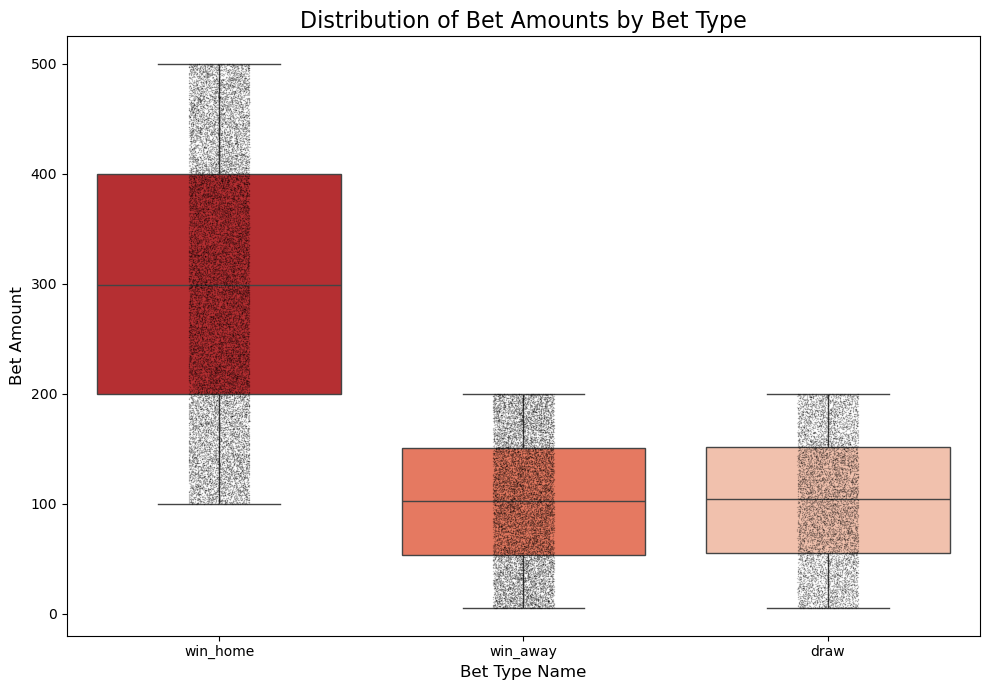

In [ ]:
plt.figure(figsize=(10, 7))

sns.boxplot(
    x='bet_type_name',
    y='bet_amount',
    data=df,
    palette='Reds_r',  # update: with Betclic color
    showfliers=False  
)
sns.stripplot(
    x='bet_type_name',
    y='bet_amount',
    data=df,
    color='black',
    alpha=0.2,  
    jitter=True ,
    size=1
)
plt.title('Distribution of Bet Amounts by Bet Type', fontsize=16)
plt.xlabel('Bet Type Name', fontsize=12)
plt.ylabel('Bet Amount', fontsize=12)
plt.tight_layout()

plt.show()

In [22]:
statistics_by_type = df.groupby('bet_type_name')['bet_amount'].describe()

print(statistics_by_type)

                 count        mean         std     min      25%     50%  \
bet_type_name                                                             
draw           10090.0  103.208428   55.975943    5.00   55.160  104.12   
win_away       14900.0  102.382740   56.437541    5.01   53.170  102.72   
win_home       25010.0  299.598246  115.395003  100.00  199.395  298.98   

                  75%     max  
bet_type_name                  
draw           151.28  199.98  
win_away       151.03  199.99  
win_home       399.63  499.97  


###  Key Insights from the distribution of bet amounts per bet type:
- The win_home bets are very different from the other two: larger amounts and most popular bet type. People bet much larger amounts on win_home: The median bet is almost 300. All win_home bets fall in a range between 100 and 500. This is also the most popular bet type, with 25,010 wagers.

- The win_away and draw bets are almost identical. Their median amounts are much lower, around 103. These bets share the same range, from 5 up to 200. They are also less common than win_home bets.

- The main insight is that there are two separate betting systems:
1. **win_home** is a special category reserved for high-value bets.
2. **win_away** and **draw** are for smaller, standard bets. 



### How do betting and match numbers evolve over time?  

In [23]:
import matplotlib.dates as mdates

/var/folders/7z/mt1hzlx95b90x3db2qfvbzxc0000gn/T/ipykernel_11509/3726217977.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df.set_index('match_date').resample('M').agg({


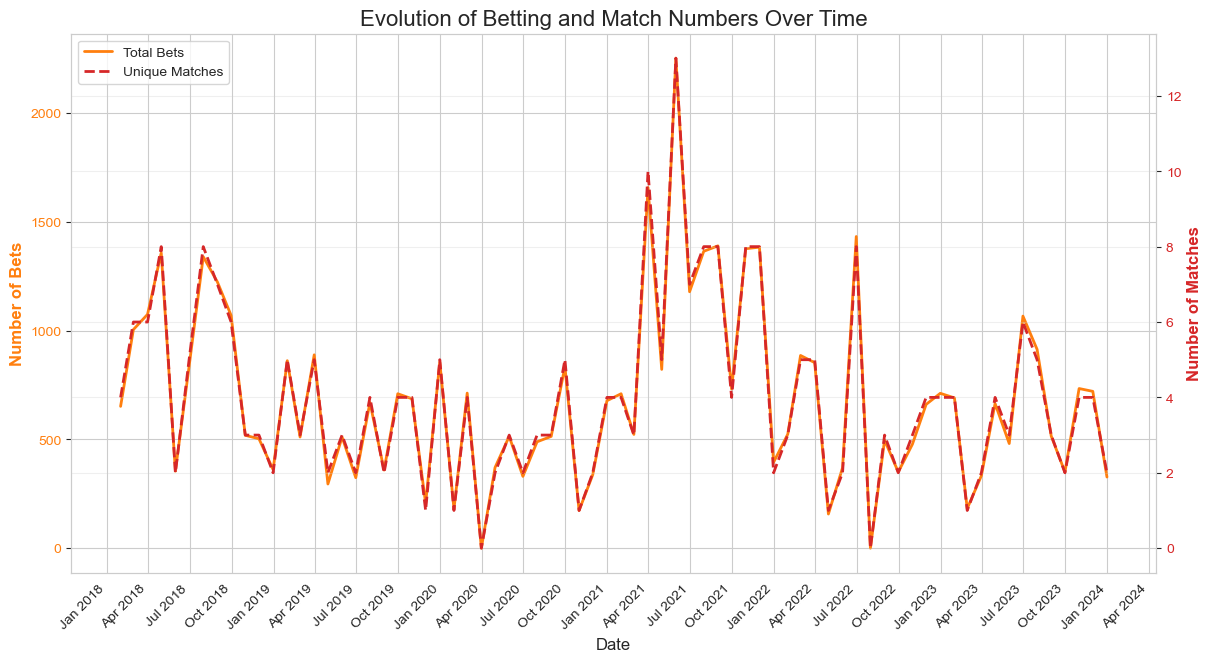

In [ ]:
monthly_stats = df.set_index('match_date').resample('M').agg({
    'bet_id': 'count',        
    'match_id': 'nunique'     
}).rename(columns={'bet_id': 'Total Bets', 'match_id': 'Unique Matches'})

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# chart for cnt_bets
color_bets = 'tab:orange'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Number of Bets', color=color_bets, fontsize=12, fontweight='bold')
ax1.plot(monthly_stats.index, monthly_stats['Total Bets'], color=color_bets, linewidth=2, label='Total Bets')
ax1.tick_params(axis='y', labelcolor=color_bets)

# chart for cnt_matches
ax2 = ax1.twinx()
color_matches = 'tab:red'  # update: for Betclic color
ax2.set_ylabel('Number of Matches', color=color_matches, fontsize=12, fontweight='bold')
ax2.plot(monthly_stats.index, monthly_stats['Unique Matches'], color=color_matches, linewidth=2, linestyle='--', label='Unique Matches')
ax2.tick_params(axis='y', labelcolor=color_matches)

# date axis, adding month and seasonal info
date_fmt = mdates.DateFormatter('%b %Y')
ax1.xaxis.set_major_formatter(date_fmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # to explore seasonal patterns (every three months)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.title('Evolution of Betting and Match Numbers Over Time', fontsize=16)
plt.grid(True, alpha=0.3)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', frameon=True)

plt.show()

### Key insights drawn from the evolution of betting and match numbers over time
1. The Core Relationship: The number of bet is strongly driven by the number of matches. Customers seem to bet simply because games are on, as when the match count drops, the bet number drop proportionally.

2. Seasonal Patterns: Normally there are three peaks during the year, it might be driven by the big sports events. 
    - Spring (March/April) - Potential driver: The climax of European domestic leagues (Premier League, La Liga) and the intense knockout stages of the UEFA Champions League.
    - Early Summer (June/July) - Driver: Major international tournaments (World Cup, Euros, Copa América). In "odd" years without these, this peak disappears or becomes a trough.
    - Season Start (October) - Driver: The return of all major European leagues after the summer break, plus the start of the Champions League group stages.

3. Anomalies: 
    - The "2020 Summer Low" (COVID-19): There is a massive crater in the middle of the year. Explanation: This is the COVID-19 Global Sports Shutdown. March–May 2020: Virtually every major league suspended play. The chart hits near zero because there were simply no matches to bet on.
    - The "2021 Summer Extremely High" (The Catch-Up Year): The highest peak on the entire chart occurs in mid-2021. Explanation: This was the "Super Summer" of sports. Because of COVID cancellations in 2020, two years' worth of events were compressed into one summer: Euro 2020 (played in June/July 2021); Copa América (played simultaneously); Tokyo Olympics (July/Aug 2021). Therefore an unprecedented saturation of daily matches, leading to the highest betting volume in the dataset.

# Statistical Analysis

In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   bet_id            50000 non-null  int64         
 1   match_id          50000 non-null  int64         
 2   user_id           50000 non-null  int64         
 3   bet_amount        50000 non-null  float64       
 4   bet_type_id       50000 non-null  int64         
 5   bet_result        50000 non-null  int64         
 6   bet_type_name     50000 non-null  object        
 7   competition_name  50000 non-null  object        
 8   team_home         50000 non-null  object        
 9   team_away         50000 non-null  object        
 10  match_date        50000 non-null  datetime64[ns]
 11  score_home        50000 non-null  int64         
 12  score_away        50000 non-null  int64         
 13  bet_odd           50000 non-null  float64       
dtypes: datetime64[ns](1), float

In [26]:
print(df.head())

   bet_id  match_id  user_id  bet_amount  bet_type_id  bet_result  \
0       1        85      246      440.67            1           1   
1       2       184       31      269.95            1           0   
2       3       219       72      334.45            1           0   
3       4       114       99       67.76            2           1   
4       5       113      410      429.80            1           0   

  bet_type_name competition_name team_home team_away match_date  score_home  \
0      win_home    Competition 6   Team 17   Team 25 2021-05-27           5   
1      win_home   Competition 14   Team 58    Team 5 2018-04-03           0   
2      win_home   Competition 16    Team 8    Team 9 2021-11-08           1   
3      win_away    Competition 9   Team 47    Team 9 2018-02-11           0   
4      win_home    Competition 8   Team 74   Team 45 2023-05-26           4   

   score_away  bet_odd  
0           4     2.13  
1           0     4.46  
2           2     4.37  
3         

## Factors Influencing bet_result
### 1. Methodology of Selecting Variables
| Variables | Action | Method |
| --- | --- | --- |
| `bet_id`, `match_id`, `user_id` | Remove | Remove identifers (noises)
| `score_home`, `score_away` | Remove | Remove data that happens after bet_result / match ends
| `bet_type_id` | Remove | Remove redundancies, keep only bet_type_name |
| `team_home`, `team_away`, `competition_name` | Remove | Remove redundancies:  They can be potiential variables: For example, certain teams play better at home -> but this is negatively correlated with bet_odd. So keep only bet_odd|
| `bet_amount` VS `bet_odd` | Check overlap | Correlation Matrix / VIF |
| `bet_amount`, `bet_odd` | If no correlation, test significance (Univariate Analysis) | Numerical variables -> Mann-Whitney U Test  |
| `bet_type_name`  | Test significance (Univariate Analysis) | Categorical variables -> Chi-Square Test  |
| All Remaining Variables | Predict drivers (Multivariate Analysis) | Logistic Regression (Which factors actually change the `bet_result`) |




### 2. Univariate Analysis: bet_amount, bet_odd

In [27]:
# Check if they have correlation
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_subset = df[['bet_amount', 'bet_odd']]
corr_matrix = X_subset.corr()
print(corr_matrix)

            bet_amount   bet_odd
bet_amount    1.000000 -0.008437
bet_odd      -0.008437  1.000000


#### Conclusion: bet_amount, bet_odd are two independant factors, with a correlation of -0.008. <br>

#### Next step:
Check if they individually have influence on the betting results. Numerical variables -> Mann-Whitney U Test



In [28]:
# check if they individually have influence on the betting results?
from scipy import stats

variables_to_check = ['bet_amount', 'bet_odd']

for col in variables_to_check:
    # 1. Statistical Test
    group_win = df[df['bet_result'] == 1][col]
    group_loss = df[df['bet_result'] == 0][col]
    stat, p = stats.mannwhitneyu(group_win, group_loss)

    print(f"\nVariable: {col}")
    print(f"Avg for Winners: {group_win.mean():.2f}")
    print(f"Avg for Losers:  {group_loss.mean():.2f}")
    print(f"P-Value: {p:.5f} ({'SIGNIFICANT' if p < 0.05 else 'Not Significant'})")


Variable: bet_amount
Avg for Winners: 218.45
Avg for Losers:  190.82
P-Value: 0.00000 (SIGNIFICANT)

Variable: bet_odd
Avg for Winners: 3.24
Avg for Losers:  3.24
P-Value: 0.76995 (Not Significant)


### Conclusion:
- bet_amount: Affect bet_result significantly, with a P-Value of 0.0000 (<< 0.05). Interpretation: Winners bet significantly more money (an average of 218.45) than losers (average: 190.82). This implies that when customers are confident (and likely to win), they increase their stake. 
- bet_odd: It's a noise (P-Value: 0.77 > 0.05). The average odds for a winning bet (3.24) are identical to a losing bet (3.24).

### 3. Univariate Analysis: bet_type_name


#### bet_type_name : Categorical variables -> Chi-Square Test
Question behind: Does the type of bet someone place (bet_type_name: 'win_home' 'win_away' 'draw') significantly change the probability of winning (bet_result)?
- Hypothesis (H0): the win rate is the same for all bet_type_name. <br>

If the P-value is < 0.05, H0 gets rejected, meaning bet_type_name is significant.

In [29]:
contingency_table = pd.crosstab(df['bet_type_name'], df['bet_result'])
print(contingency_table)


bet_result         0      1
bet_type_name              
draw            8543   1547
win_away        8756   6144
win_home       13919  11091


In [30]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.5f} ({'SIGNIFICANT' if p < 0.05 else 'Not Significant'})")


Chi-Square Statistic: 2702.5089
P-Value: 0.00000 (SIGNIFICANT)


In [31]:
summary_table = pd.crosstab(df['bet_type_name'], df['bet_result'])

summary_table.columns = ['Lost (0)', 'Won (1)']
summary_table['Total'] = summary_table['Lost (0)'] + summary_table['Won (1)']
summary_table['Win Rate'] = ((summary_table['Won (1)'] / summary_table['Total']) * 100).round(1)

print(summary_table)

               Lost (0)  Won (1)  Total  Win Rate
bet_type_name                                    
draw               8543     1547  10090      15.3
win_away           8756     6144  14900      41.2
win_home          13919    11091  25010      44.3


### Conclusion: 
- Bet_result is greatly affected by bet_type_name. Because the P-Value is 0.00000 (<< 0.05)
- Interpretation: If bet_type_name is "draw", the customer is highly likely to lose, with a win rate of 15.3%; if bet_type_name is "win_home", with the highest chance to win, the customer has a win rate of 44.3%, almost 3x more likely to win than if they bet on a draw.

### 4. Multivariate Analysis - Logistic Regression
- bet_result (The Target)
- bet_amount (Numerical, confirmed significant)
- bet_type_name (Categorical, confirmed significant)



In [32]:
import statsmodels.api as sm
import numpy as np

df_model = df[['bet_amount', 'bet_type_name', 'bet_result']].copy()

df_model['bet_amount'] = pd.to_numeric(df_model['bet_amount'])
df_model['bet_result'] = pd.to_numeric(df_model['bet_result'])

df_encoded = pd.get_dummies(df_model, columns=['bet_type_name'], drop_first=True, dtype=int) #drop_first=True : drop one category to serve as Baseline, to reduce redundancy.

y = df_encoded['bet_result']
X = df_encoded.drop('bet_result', axis=1)
X = sm.add_constant(X) # the bias

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.631911
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             bet_result   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49996
Method:                           MLE   Df Model:                            3
Date:                Thu, 20 Nov 2025   Pseudo R-squ.:                 0.04529
Time:                        14:31:17   Log-Likelihood:                -31596.
converged:                       True   LL-Null:                       -33094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.6997      0.030    -57.558      0.000      -1.758      

### Interpretation:
#### A. Is the Logit Regression model trustworthy? 
Yes.<br>
The model found the real patterns, with a LLR P-Value of 0.000 (< 0.05); The model explains 4.5% of the results, with a Pseudo R-squ of 0.04529. Considering in sports betting field, the prediction is complicated, the rest 95.5% of the result might be determined by other variables such as luck, weather, or player factors.

#### B. The variables
1. bet_type_name_win_home: It's the most significant factor, with the highest coefficient, 1.4991 and a P-Value of 0.000 (<0.05). Meaning betting on the "Home Team" gives the highest probability of winning among all options. 


2. bet_type_name_win_away: It's also quite significant, with a coefficient of 1.3545 and a P-Value of 0.000 (<0.05). Meaning betting on the "Away Team" significantly increases the probability of winning compared to the Baseline (Draw).


3. const (bet_type_name_draw): This is significant negative factor affecting bet_result, with a negative coefficient of -1.6997 and a P-Value of 0.000 (<0.05). This means the probability of winning a "Draw" bet is naturally very low.


4. bet_amount: It's a noise, with a P-Value of 0.381 (> 0.05) and a tiny coefficient, -0.00008. It has zero effect on bet_result. It showed as a factor in the univariate test, but that test result was actually affected by bet_type_name, meaning people bet more on Home Wins, which drives the bet_result more wins.

In [33]:
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print("--- ODDS RATIOS ---")
print(np.exp(conf))


--- ODDS RATIOS ---
                              5%       95%  Odds Ratio
const                   0.172468  0.193633    0.182745
bet_amount              0.999713  1.000110    0.999911
bet_type_name_win_away  3.637310  4.127555    3.874686
bet_type_name_win_home  4.169736  4.807983    4.477502


### C. How many times more likely to win the bet if the customer choose different bet types ?
1. Win Home : The safest bet type. When someone bets on the Home Team, they are 4.48 times more likely to win compared to betting on a Draw (the baseline).

2. Win Away : Still a very good bet, but statistically slightly riskier than a Home bet. When someone bets on the Away Team, they are 3.87 times more likely to win compared to betting on a Draw.

3. Draw : Winning a Draw is very low. Since it is far below 1.0, it means the base odds of winning a Draw are very poor

# Draft

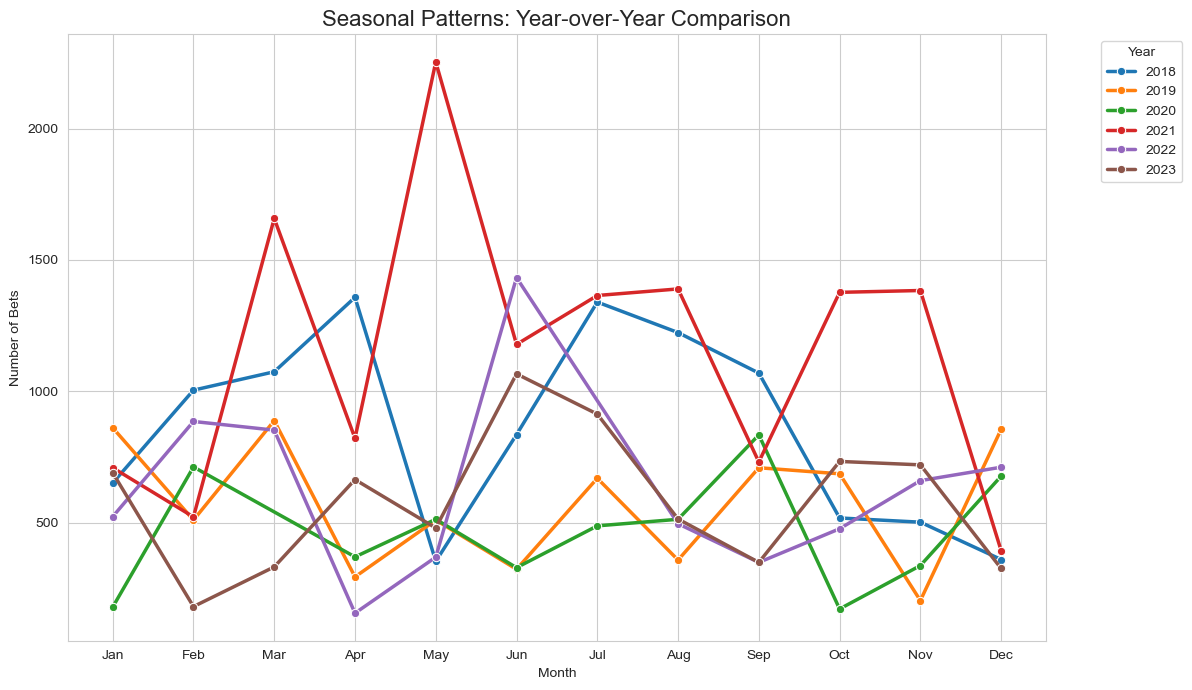

In [34]:
# To compare seasonal patterns, plot overlays year over year
import calendar

df['Year'] = df['match_date'].dt.year
df['Month'] = df['match_date'].dt.month

# aggregate cnt of bets by year and month
seasonal_data = df.groupby(['Year', 'Month'])['bet_id'].count().reset_index()
seasonal_data.rename(columns={'bet_id': 'Total Bets'}, inplace=True)

# plot: X=Month, Y=Bets, Line Color=Year
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=seasonal_data, 
    x='Month', 
    y='Total Bets', 
    hue='Year',         
    palette='tab10',     
    marker='o', 
    linewidth=2.5
)

plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)])

plt.title('Seasonal Patterns: Year-over-Year Comparison', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Number of Bets')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside

plt.tight_layout()
plt.show()

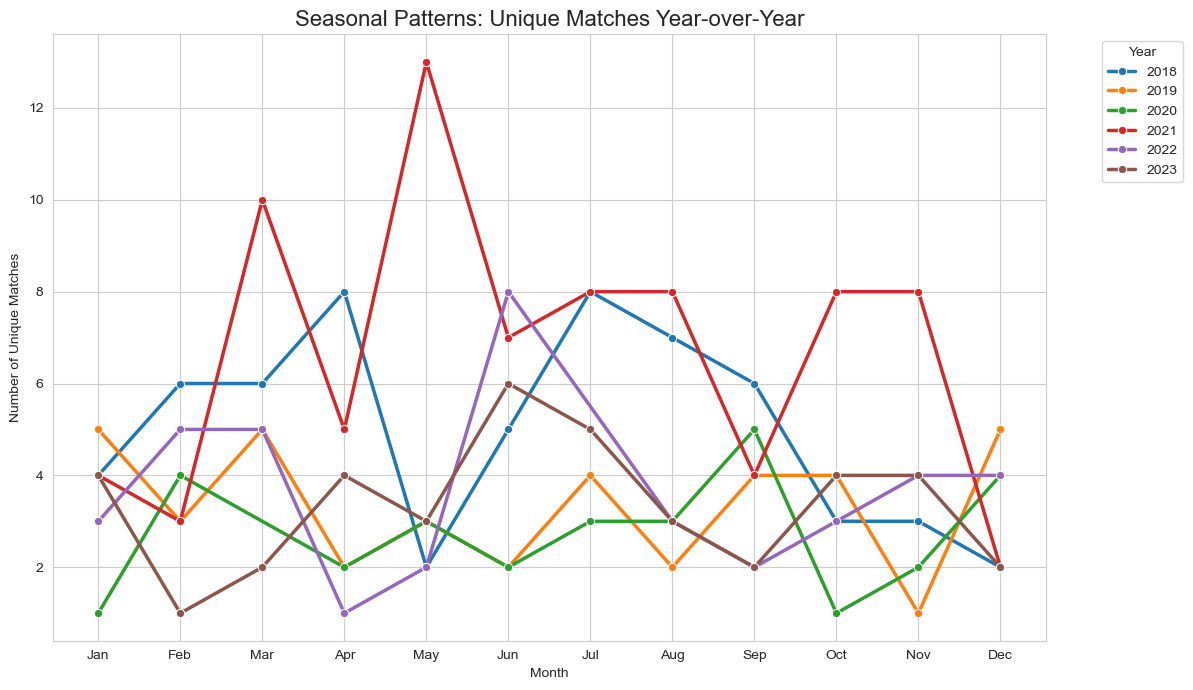

In [35]:
seasonal_matches = df.groupby(['Year', 'Month'])['match_id'].nunique().reset_index()
seasonal_matches.rename(columns={'match_id': 'Unique Matches'}, inplace=True)

#  Plotting: X=Month, Y=Unique Matches, Line Color=Year
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=seasonal_matches, 
    x='Month', 
    y='Unique Matches',   # Updated y-variable
    hue='Year',           
    palette='tab10',       
    marker='o', 
    linewidth=2.5
)

# Formatting
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[i] for i in range(1, 13)])

plt.title('Seasonal Patterns: Unique Matches Year-over-Year', fontsize=16) # Updated Title
plt.xlabel('Month')
plt.ylabel('Number of Unique Matches') # Updated Label
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The Golden Rule of Odds Ratios in Logistic Regression

OR = 1.0: Neutral. The variable does nothing.

OR > 1.0: Positive. The event is more likely to happen. (e.g., 2.0 means "Twice as likely").

OR < 1.0: Negative. The event is less likely to happen. (e.g., 0.5 means "Half as likely").

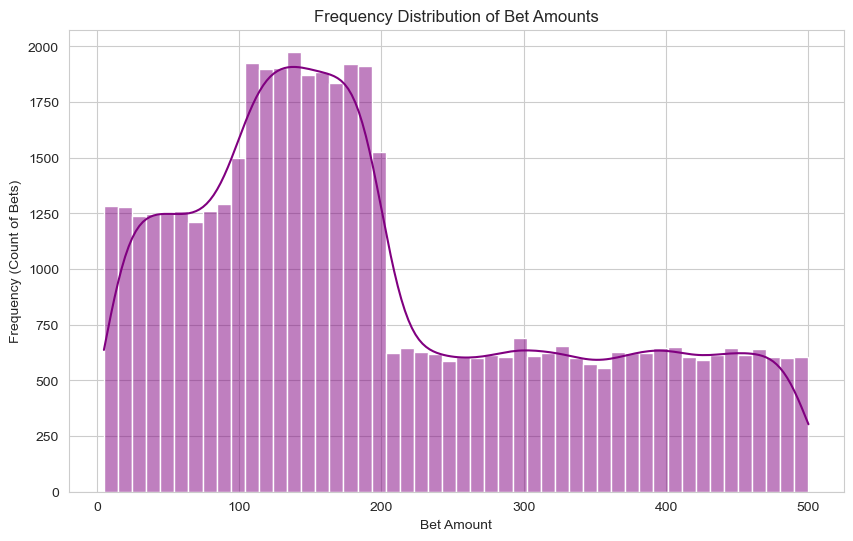

In [36]:
# Distribution of bet_amounts
plt.figure(figsize=(10, 6))

sns.histplot(df['bet_amount'], bins=50, kde=True, color='purple')

plt.title('Frequency Distribution of Bet Amounts')
plt.xlabel('Bet Amount')
plt.ylabel('Frequency (Count of Bets)')
plt.show()